In [1]:
import pandas as pd
import numpy as np

1. Import confirmed, recovered and deaths data set for a given country

In [76]:
confirmed = pd.read_csv('Corona-Virus-Dataset/time_series_covid_19_confirmed.csv')
recovered = pd.read_csv('Corona-Virus-Dataset/time_series_covid_19_recovered.csv')
deaths = pd.read_csv('Corona-Virus-Dataset/time_series_covid_19_deaths.csv')

2. Pre-process the datasets

In [77]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


In [78]:
recovered = reformat(recovered, 'Italy', 'Recovered cases')
confirmed = reformat(confirmed, 'Italy', 'Confirmed cases')
deaths = reformat(deaths, 'Italy', 'Deaths cases')

recovered.head()

,Recovered cases
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [79]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

In [80]:
deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [81]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [82]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

In [83]:
recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [84]:
data = recovered.merge(infected, on='Date')

In [198]:
dataframe = pd.concat([data['Date'],data['Recovered cases'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

To go on I think it would be better to have a larger data set

In [199]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered cases', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [200]:
dataframe = dataframe.set_index('Date')

In [201]:
dataframe

,Recovered cases,Infected cases t-7,Infected cases t-8,Infected cases t-9,Infected cases t-10,Infected cases t-11,Infected cases t-12,Infected cases t-13,Infected cases t-14,Infected cases t-15,Infected cases t-16,Infected cases t-17,Infected cases t-18,Infected cases t-19,Infected cases t-20,Infected cases t-21
Date,,,,,,,,,,,,,,,,
2/12/20,0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2/13/20,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2/14/20,0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2/15/20,0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
2/16/20,0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
2/17/20,0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
2/18/20,0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0
2/19/20,0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0
2/20/20,0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0


In [202]:
X = dataframe.values

### Persistence model

In [203]:
# split into train and test sets
train, test = X[:len(X)-10], X[len(X)-10:]
train_y, train_X = train[:,0], train[:,1:]
test_y, test_X = test[:,0], test[:,1:]

One of the simplest methods for predicting the future behavior of a time series is the so-called persistence model. Persistence implies that future values of the time series are calculated on the assumption that conditions remain unchanged between “current” time  and future time $t + T_H$. For a stationary time series—one whose mean and variance do not change over time—a straightforward implementation of the persistence model is simply

$$\hat{y}(t+T_H) = y(t)$$

which may be referred as “dull persistence.”

Test MSE: 143632.721


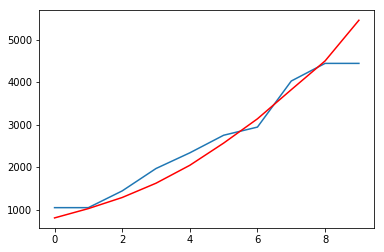

In [204]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    # I added a slight change, by using the mean of the 14 observations in order to have one dimension input to the
    # persistence model
    yhat = model_persistence(np.mean(x))
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
pyplot.plot(test_y)
pyplot.plot(predictions, color='red')
pyplot.show()

The expected number of recovered individuals for the next ten days are plotted (blue) compared to the predictions from the model (red).

In [205]:
# if we try to predict the next seven days we have MSE Test MSE: 193348.358
# if we try to predict the next ten days we have MSE Test MSE: 143632.721

### Linear regression model

In [206]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

If we take out the first 15 days due to noise, unstability of covid-19 progress

In [207]:
dataframe_new = dataframe.iloc[15:,:]

In [208]:
y = dataframe_new['Recovered cases'].values
X = dataframe_new.iloc[:,1:].values

In [209]:
dataframe_new.loc[:,'Recovered cases'] = dataframe_new.loc[:,'Recovered cases'].apply(pd.to_numeric)


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


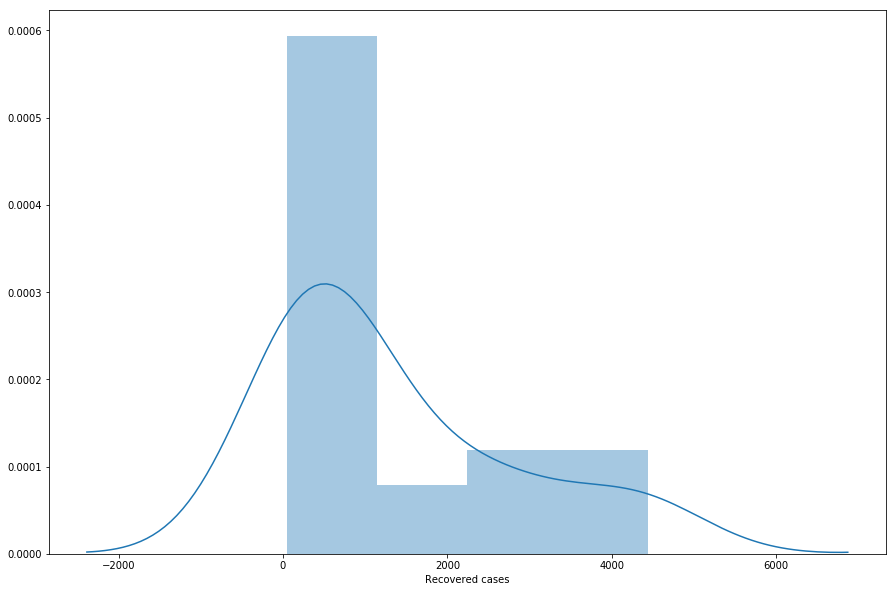

In [210]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataframe_new['Recovered cases'])

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [217]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [218]:
y_pred = regressor.predict(X_test)


In [219]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,724,1074.651755
1,622,658.349037
2,4440,4239.615657
3,1045,729.949268
4,4025,4542.258565


In [220]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 283.9388865474709
Mean Squared Error: 106249.03560204004
Root Mean Squared Error: 325.9586409378344


In [221]:
coeff_df = pd.DataFrame(regressor.coef_, dataframe.iloc[:,1:].columns, columns=['Coefficient'])  
coeff_df

,Coefficient
Infected cases t-7,0.037598
Infected cases t-8,1.050930
Infected cases t-9,-1.081589
Infected cases t-10,0.583245
Infected cases t-11,0.723428
Infected cases t-12,0.595558
Infected cases t-13,-2.157377
Infected cases t-14,0.192759
Infected cases t-15,-0.445927
Infected cases t-16,-1.891586


For a unit increase in the number of recovered individuals at time t, that means there is:
- An increase of 21 infected at day t-20
- A decrease of 13 infected at day t-18

We see that the closer we are to the recovery date, the lower the number of infected cases has an impact on the number od recovered cases 

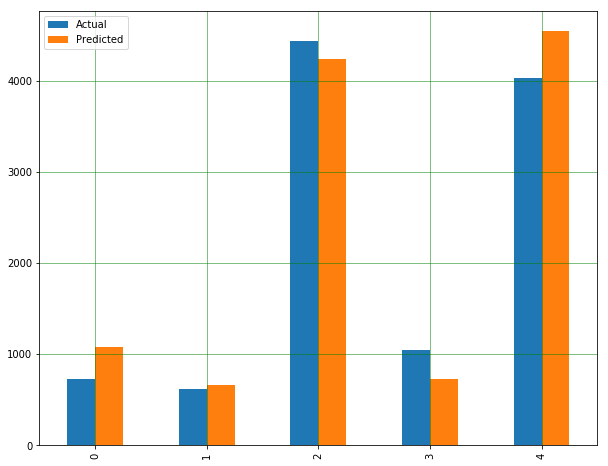

In [222]:
df.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

There are many factors that may have contributed to this inaccuracy, for example :

- **Need more data**: We need to have a huge amount of data to get the best possible prediction.
- **Bad assumptions**: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help us determine that.
- **Poor features**: The features we used may not have had a high enough correlation to the values we were trying to predict.